In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import glob, os, sys, yaml, subprocess, itertools, sparse

who_variants_combined = pd.read_csv("who_confidence_2021.csv")
drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")
samples_summary = pd.read_csv("../data/samples_summary.csv")
snp_scheme = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
snp_scheme["#lineage"] = snp_scheme["#lineage"].str.replace("lineage", "")
snp_scheme.rename(columns={"#lineage": "Lineage"}, inplace=True)

lineages = pd.read_csv("../data/combined_lineages_samples.csv", low_memory=False)
solo_results = pd.read_excel("../data/SOLO primary_STATA_ver18Feb2023.xlsx", sheet_name=None)

if len(solo_results) == 1:
    solo_results = solo_results[list(solo_results.keys())[0]]
    
solo_results = solo_results.rename(columns={"variant":"mutation"})
solo_results["Initial_Confidence_Grading"] = solo_results["Initial_Confidence_Grading"].replace('4) Not assoc w R - interim', '4) Not assoc w R - Interim')
    
import warnings
warnings.filterwarnings(action='ignore')

# utils files are in a separate folder
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *
from data_utils import *

# CHANGE ANALYSIS DIR BEFORE RUNNING THE NOTEBOOK!
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'
from functools import reduce

Anything Num_Isolates < 5 should be uncertain 

Tier 2 can only be in the highest categories if there is MIC evidence supporting it

Write an email to everybody about the results for the new drugs: BDQ, LZD, PTM, DLM, CFZ

Associations added to list only if they are both in WHO and ALL datasets. 

In [2]:
drugs_lst = os.listdir(analysis_dir)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

# Write Final Dataframes for the Binary Analysis to an Excel File

Each drug will have a separate Excel file. Each file will have 16 sheets, one for each model.

For INH, surprising that hadA variants are found with high associations. Might be homoplastic!
For PZA, surprising that clpC1_c.2302T>C co-occurs with pncA_p.His57Asp

In [3]:
def get_unpooled_table_by_tier(drug, tiers_lst, folder, model_prefix):
    
    ################## 1. READ IN RIDGE REGRESSION RESULTS ##################
    model_permute = pd.read_csv(os.path.join(analysis_dir, drug, folder, model_prefix, "model_analysis.csv")).query("~mutation.str.contains('PC')")
    
    ################## 2. READ IN LRT RESULTS ##################
    LRTresults = pd.read_csv(os.path.join(analysis_dir, drug, folder, model_prefix, "LRT_results.csv"))

    # because the p-values are NaN for the FULL model row, they will be removed, so then the dataframes can be merged using inner
    LRTresults = add_pval_corrections(LRTresults.iloc[1:, ])
    
    # combine results into a single dataframe for easy searching. REMOVE BONFERRONI AND COEFS
    combined_results = model_permute[model_permute.columns[~model_permute.columns.str.contains("|".join(["Bonferroni", "coef"]))]].merge(LRTresults[["mutation", "LRT_pval", "BH_LRT_pval", "LRT_neutral_pval", "BH_LRT_neutral_pval"]]
                                                                                                                  , on="mutation", how="inner")

    combined_results["Tier"] = tiers_lst[-1]

    # columns to return, in the desired order
    keep_cols = ['mutation', 'Tier', 'predicted_effect', 'position', 'confidence', 'Odds_Ratio',
                           #'OR_LB', 'OR_UB', 
                 'pval', 'BH_pval', 'neutral_pval', 'BH_neutral_pval', 'LRT_pval', 'BH_LRT_pval', 'LRT_neutral_pval', 'BH_LRT_neutral_pval']

    keep_cols += ['Num_Isolates', "Mut_R", "Mut_S", "NoMut_S", "NoMut_R", 
                  'PPV', 'NPV', 'Sens', 'Spec', 'LR+', 'LR-',
                   'PPV_LB', 'PPV_UB', 'NPV_LB', 'NPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB',
                   'Spec_UB', 'LR+_LB', 'LR+_UB', 'LR-_LB', 'LR-_UB'
                   ]

    return combined_results[keep_cols]

In [4]:
def add_significance_category(df, drug, model_path):
    '''
    Add significance category annotations, in the form of integers. Add the ones with the fewest requirements first, and then progressively add
    '''
    
    col_name = "regression_confidence"
    df = df.reset_index(drop=True)
    df[["Tier", "synonymous"]] = df[["Tier", "synonymous"]].astype(int)
    
    # lower significance threshold for tier 2 genes and synonymous mutations
    if df["Tier"].values[0] == 2 or df["synonymous"].values[0] == 1:
        thresh = 0.01
    else:
        thresh = 0.05
        
    # anything without Num_Isolates >= 5 is Uncertain because it's too rare to make conclusions
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] > 1) & (df["Num_Isolates"] >= 5) & (df["PPV_LB"] >= 0.25), col_name] = "Possible Assoc w R"
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] < 1) & (df["Num_Isolates"] >= 5) & (df["NPV_LB"] >= 0.25), col_name] = "Possible Assoc w S"
    
    # get additional evidence from the LRT to be classified as Assoc w R/S. Only classify Tier 1 here
    # Tier 2 mutations can only be upgraded to the highest categories if there is MIC evidence supporting it
    df.loc[(df[col_name] == "Possible Assoc w R") & (df["BH_LRT_pval"] < thresh) & (df["Tier"] == 1), col_name] = "Assoc w R"
    df.loc[(df[col_name] == "Possible Assoc w S") & (df["BH_LRT_pval"] < thresh) & (df["Tier"] == 1), col_name] = "Assoc w S"
    
    # phenos = ALL/WHO is the middle part of the path, so split and keep the first and last parts
    MIC_model_path = "/".join([model_path.split("/")[0], model_path.split("/")[-1]])
    MIC_model_analysis = pd.read_csv(os.path.join(analysis_dir, drug, "MIC", MIC_model_path, "model_analysis.csv")).query("~mutation.str.contains('PC')")
    
    # neutral mutations: not significant in regression AND significant in the neutral LRT test AND present at high enough frequency
    # should be in the lowest tail of the p-value.
    # so a mutation is significant in regression if p-value < 0.05, then a mutation is significant in the neutral test if p-value > 0.95
    # This means that more than 95% of permuted samples are NOT AS EXTREME as the test statistic, indicating the probably the test statistic is not significant
    df.loc[(df["BH_neutral_pval"] < thresh) & (df["BH_LRT_neutral_pval"] < thresh) & (df["Num_Isolates"] >= 5), col_name] = "Neutral"
        
    # upgrade mutations in the Possible Assoc categories if they have a significant associations with MIC
    # downgrade mutations in the top categories if they DO NOT HAVE significant associations with MIC
    # AT THIS POINT, THE HIGHEST A TIER 2 MUTATION CAN BE IS AT POSSIBLE
        
    df = df.merge(MIC_model_analysis[["mutation", "coef", "BH_pval"]].rename(columns={"coef": "MIC_coef", "BH_pval": "BH_MIC_pval"}), on="mutation", how="left")
    mic_evidence_lst = []
    
    for i, row in df.iterrows():

        OR, OR_BH_pval, MIC_coef, BH_MIC_pval = row[["Odds_Ratio", "BH_pval", "MIC_coef", "BH_MIC_pval"]].values
        
        if not pd.isnull(MIC_coef) and not pd.isnull(row[col_name]):
                        
            if "Possible" in row[col_name] or row["Tier"] == 2:
                
                # only upgrade or downgrade if the MIC coefficient is significant
                # if it is not significant, then don't make any changes
                if BH_MIC_pval < thresh:

                    # keep track of mutations that we use MIC evidence for
                    mic_evidence_lst.append(row["mutation"])

                    # HANDLE POSSIBLE MUTATIONS: if MIC evidence agrees and is significant, upgrade
                    # if MIC evidence disagrees or is NOT significant, downgrade
                    if OR > 1:
                        if MIC_coef > 0:
                            df.loc[i, col_name] = "Assoc w R"
                        else:
                            df.loc[i, col_name] = "Uncertain"

                    elif OR < 1:
                        if MIC_coef < 0:
                            df.loc[i, col_name] = "Assoc w S"
                        else:
                            df.loc[i, col_name] = "Uncertain"
                            
    # all other are uncertain
    df[col_name] = df[col_name].fillna("Uncertain")
    df.loc[df["mutation"].isin(mic_evidence_lst), "Use_MIC_Evidence"] = 1
    df["Use_MIC_Evidence"] = df["Use_MIC_Evidence"].fillna(0).astype(int)
    return df

In [5]:
def add_single_lineage_annotations_to_model(drug, df, folder, model_path):
    '''
    Annotate mutations that are present in a single lineage. Basically just a flag when performing further analyses.
    
    It's done at the lowest level because that's the output of Coll2014. So it will not flag mutations that are all present in L2, unless L2 was the deepest category fast-lineage-caller identified.
    '''
    
    model_matrix = pd.read_pickle(os.path.join(analysis_dir, drug, folder, model_path, "model_matrix.pkl"))

    lineages_single_model = lineages.query("~Coll2014.str.contains(',')")
    model_matrix = model_matrix.loc[model_matrix.index.isin(lineages_single_model['Sample_ID'].values)]
    model_matrix = model_matrix.merge(lineages_single_model[["Coll2014", "Sample_ID"]], left_index=True, right_on="Sample_ID")
    
    single_lineage_mutations = {}

    for col in model_matrix.columns:

        if col not in ["Sample_ID", "Coll2014"]:

            mutation_lineages = np.unique(model_matrix.loc[model_matrix[col]==1]["Coll2014"].values)

            # there is only one lineage present
            if len(mutation_lineages) == 1:
                single_lineage_mutations[col] = mutation_lineages[0]
    
    # add lineage annotations to dataframe. Only mutations that are in the model matrix are in this dictionary
    df["single_lineage"] = df["mutation"].map(single_lineage_mutations)
    return df

In [6]:
def export_binary_analyses(drugs_lst, read_folder, write_folder, analyses_lst):
    
    if not os.path.isdir(f"../results/{write_folder}"):
        os.mkdir(f"../results/{write_folder}")
    
    for drug in np.sort(drugs_lst):
        
        all_analyses = {}

        for i, model_path in enumerate(analyses_lst):
            # some may not be there. Usually this is Pretomanid because there are no tier 2 genes or WHO phenotypes
            if os.path.isfile(os.path.join(analysis_dir, drug, read_folder, model_path, "model_matrix.pkl")):
                            
                tiers_lst = [["1", "2"] if "1+2" in model_path else ["1"]][0]
                phenos_name = ["ALL" if "phenos=ALL" in model_path else "WHO"][0]
                
                # if "dropAF_withSyn_unpooled" in model_path:
                phenos_name = ["ALL" if "ALL" in model_path else "WHO"][0]
                add_analysis = get_unpooled_table_by_tier(drug, tiers_lst, read_folder, model_path)
                
                add_analysis["pool_type"] = model_path.split("_")[-1]
                add_analysis["synonymous"] = int("withSyn" in model_path)
                
                add_analysis = add_analysis[add_analysis.columns[~add_analysis.columns.str.contains("|".join(["coef", "Bonferroni"]))]]
                add_analysis = add_significance_category(add_analysis, drug, model_path)

                # add annotation denoting whether a mutation is only present in a single lineage
                add_analysis = add_single_lineage_annotations_to_model(drug, add_analysis, read_folder, model_path)
                
                # for models with synonymous mutations, keep only the data for the synonymous ones
                # the data for nonsyn mutations will come from the noSyn models
                if "withSyn" in model_path:
                    add_analysis = add_analysis.query("predicted_effect in ['synonymous_variant', 'stop_retained_variant', 'initiator_codon_variant']")
                    
                # for models with pooling, only keep the results for the pooled mutations
                if "poolSeparate" in model_path:
                    add_analysis = add_analysis.query("predicted_effect in ['lof', 'inframe']")
                    
                # add SOLO V2 gradings
                add_analysis = add_analysis.merge(solo_results.query("drug==@drug")[["mutation", "Initial_Confidence_Grading"]], on="mutation", how="left")

                # the phenotype category is only relevant for the binary analysis
                if read_folder == "BINARY":
                    add_analysis["Phenos"] = ["ALL" if "phenos=ALL" in model_path else "WHO"][0]

                add_analysis.rename(columns={"confidence": "confidence_V1"}, inplace=True)
                all_analyses[model_path.replace("phenos=", "").replace("/", ",").replace("tiers=", "T").replace("dropAF_", "")] = add_analysis
        
        with pd.ExcelWriter(f"../results/{write_folder}/{drug}.xlsx") as file:
            for key, val in all_analyses.items():
                val.to_excel(file, sheet_name=key, index=False)
                    
        print(f"Finished {len(all_analyses)} analyses for {drug}")
        # return all_analyses

In [7]:
# hard coded paths to preserve the model hierarchy
binary_analyses_lst = [
                        ########### Tier 1, WHO phenos ###########
                        "tiers=1/phenos=WHO/dropAF_noSyn_unpooled",
                        "tiers=1/phenos=WHO/dropAF_noSyn_poolSeparate",
                        "tiers=1/phenos=WHO/dropAF_withSyn_unpooled",
                        # ########### Tiers 1 + 2, WHO phenos ###########
                        # "tiers=1+2/phenos=WHO/dropAF_noSyn_unpooled",
                        # "tiers=1+2/phenos=WHO/dropAF_noSyn_poolSeparate",
                        # "tiers=1+2/phenos=WHO/dropAF_withSyn_unpooled",
                        ########### Tier 1, ALL phenos ###########
                        "tiers=1/phenos=ALL/dropAF_noSyn_unpooled",
                        "tiers=1/phenos=ALL/dropAF_noSyn_poolSeparate",
                        "tiers=1/phenos=ALL/dropAF_withSyn_unpooled",
                        # ########### Tiers 1 + 2, ALL phenos ###########
                        # "tiers=1+2/phenos=ALL/dropAF_noSyn_unpooled",
                        # "tiers=1+2/phenos=ALL/dropAF_noSyn_poolSeparate",
                        # "tiers=1+2/phenos=ALL/dropAF_withSyn_unpooled",
                      ]

mic_analyses_lst = ["tiers=1/dropAF_noSyn_unpooled",
                    "tiers=1/dropAF_noSyn_poolSeparate",
                    "tiers=1/dropAF_withSyn_unpooled",
                    # "tiers=1+2/dropAF_noSyn_unpooled",
                    # "tiers=1+2/dropAF_noSyn_poolSeparate",
                    # "tiers=1+2/dropAF_withSyn_unpooled",
                   ]
    
# # export_binary_analyses(drugs_lst, "BINARY", "NEW", binary_analyses_lst)

# drugs_lst = ["Rifampicin", "Moxifloxacin", "Levofloxacin", "Pretomanid", "Bedaquiline", "Delamanid", "Clofazimine", "Linezolid"]
drugs_lst = ["Pretomanid"]
export_binary_analyses(drugs_lst, "BINARY", "BINARY", binary_analyses_lst)
# drugs_lst = ["Isoniazid", "Rifampicin", "Moxifloxacin", "Levofloxacin", "Pretomanid", "Bedaquiline", "Delamanid", "Clofazimine", "Linezolid"]

Finished 3 analyses for Pretomanid


In [8]:
def create_significance_summary_by_drug(drug, folder):
    
    col_name = "regression_confidence"
    drug_excel_file = pd.read_excel(f"../results/{folder}/{drug}.xlsx", sheet_name=None)
    summary_df = pd.DataFrame()

    # dropna drops PCs (because they are NaN in the univariate stats columns) and also the dropped mutations because they are NaN in most columns
    for model in drug_excel_file.keys():
        summary_df = pd.concat([summary_df, pd.DataFrame(drug_excel_file[model][col_name].value_counts(dropna=False))], axis=1)

    summary_df = summary_df.fillna(0).astype(int)
    summary_df.columns = drug_excel_file.keys()

    sig_groups = ["Assoc w R", "Possible Assoc w R", "Uncertain", "Possible Assoc w S", "Assoc w S", "Neutral"]

    missing_groups = list(set(sig_groups) - set(summary_df.index.values))
    summary_df = pd.concat([summary_df, pd.DataFrame(0, index=missing_groups, columns=summary_df.columns)])

    return summary_df.loc[sig_groups], drug_excel_file

In [14]:
summary_dfs_dict = {}
full_results_dict = {}

drugs_lst = ["Rifampicin", "Moxifloxacin", "Isoniazid"]

for drug in np.sort(drugs_lst):
    res = create_significance_summary_by_drug(drug, "BINARY")
    summary_dfs_dict[drug] = res[0]
    full_results_dict[drug] = res[1]

In [15]:
def combine_results_single_drug(full_results_dict, drug):
    
    del_cols = ["Phenos", "pool_type", "synonymous", "confidence_V1", "pval", "neutral_pval", "LRT_pval", "LRT_neutral_pval"]
    
    WHO_combined = []
    ALL_combined = []

    for name, df in full_results_dict[drug].items():

        df = df[df.columns[~df.columns.isin(del_cols)]]
        
        if "WHO" in name:
            WHO_combined.append(df)
        elif "ALL" in name:
            ALL_combined.append(df)
        else:
            print(name)

    if drug != "Pretomanid":
        assert len(WHO_combined) == len(ALL_combined)
        assert len(pd.concat(ALL_combined)) == len(pd.concat(ALL_combined).drop_duplicates("mutation"))
        ALL_combined = pd.concat(ALL_combined)
    
    assert len(pd.concat(WHO_combined)) == len(pd.concat(WHO_combined).drop_duplicates("mutation"))
    WHO_combined = pd.concat(WHO_combined)
    
    return WHO_combined, ALL_combined

In [16]:
WHO_phenos_results = {}
ALL_phenos_results = {}

for drug in drugs_lst:
    print(f"{drug}")
    WHO_df, ALL_df = combine_results_single_drug(full_results_dict, drug)

    if drug != "Pretomanid":
        #print(WHO_df["regression_confidence"].value_counts())
        ALL_phenos_results[drug] = ALL_df
        assert len(ALL_df.query("regression_confidence != 'Uncertain' & Num_Isolates < 5")) == 0
        assert len(ALL_df.query("regression_confidence not in ['Uncertain', 'Neutral'] & Odds_Ratio > 1 & PPV_LB < 0.25")) == 0
        assert len(ALL_df.query("regression_confidence not in ['Uncertain', 'Neutral'] & Odds_Ratio < 1 & NPV_LB < 0.25")) == 0
    
    #print(ALL_df["regression_confidence"].value_counts())
    WHO_phenos_results[drug] = WHO_df
    assert len(WHO_df.query("regression_confidence != 'Uncertain' & Num_Isolates < 5")) == 0
    assert len(WHO_df.query("regression_confidence not in ['Uncertain', 'Neutral'] & Odds_Ratio > 1 & PPV_LB < 0.25")) == 0
    assert len(WHO_df.query("regression_confidence not in ['Uncertain', 'Neutral'] & Odds_Ratio < 1 & NPV_LB < 0.25")) == 0

Rifampicin
Moxifloxacin
Isoniazid


In [17]:
def numerically_encode_confidence(conf_level):

    if conf_level == 'Uncertain':
        return 0
    elif 'Possible' in conf_level:
        return 1
    else:
        return 2


def WHO_ALL_prioritization_scheme(WHO_conf, ALL_conf):

    if WHO_conf == 0:
        return 0

    # if WHO possible and ALL assoc, return interim. Else, uncertain
    elif WHO_conf == 1:
        if ALL_conf == 2:
            return 1.5
        else:
            return 0

    # if WHO assoc and ALL uncertain, return uncertain. Else, return assoc
    elif WHO_conf == 2:
        if ALL_conf == 0:
            return 0
        else:
            return 2

In [18]:
# all_possibilities = list(itertools.product([0, 1, 2], [0, 1, 2]))

# for a, b in all_possibilities:

#     c = WHO_ALL_prioritization_scheme(a, b)
#     print(f"WHO: {a}, ALL: {b}, Result: {c}")

In [13]:
def combine_WHO_ALL_results(drug, WHO_phenos_results, ALL_phenos_results):

    full_mutation_lst = list(set(WHO_phenos_results[drug].mutation).union(set(ALL_phenos_results[drug].mutation)))
    both_lst = list(set(WHO_phenos_results[drug].mutation).intersection(set(ALL_phenos_results[drug].mutation)))
    
    WHO_lst = list(set(WHO_phenos_results[drug].mutation) - set(ALL_phenos_results[drug].mutation))
    ALL_lst = list(set(ALL_phenos_results[drug].mutation) - set(WHO_phenos_results[drug].mutation))

    interim_lst = []
    uncertain_lst = []
    
    for mutation in both_lst:
    
        ALL_conf = ALL_phenos_results[drug].query("mutation==@mutation")["regression_confidence"].values[0]
        WHO_conf = WHO_phenos_results[drug].query("mutation==@mutation")["regression_confidence"].values[0]
    
        ALL_conf = numerically_encode_confidence(ALL_conf)
        WHO_conf = numerically_encode_confidence(WHO_conf)

        if WHO_conf == 0:
            WHO_lst.append(mutation)

        # if WHO possible and ALL assoc, return interim. Else, uncertain
        elif WHO_conf == 1:
            WHO_lst.append(mutation)

            # get the statistics (OR, Sens, Spec, etc.) estimated on the WHO dataset, but up- or downgrade the grading
            if ALL_conf == 2:
                interim_lst.append(mutation)
            else:
                uncertain_lst.append(mutation)
    
        # if WHO assoc and ALL uncertain, return uncertain. Else, return assoc
        elif WHO_conf == 2:
            if ALL_conf == 0:
                ALL_lst.append(mutation)
            else:
                WHO_lst.append(mutation)
    
    # check that we got all mutations
    assert len(set(WHO_lst).union(ALL_lst).symmetric_difference(full_mutation_lst)) == 0

    WHO_final = WHO_phenos_results[drug].query("mutation in @WHO_lst")
    WHO_final["Phenos"] = "WHO"

    ALL_final = ALL_phenos_results[drug].query("mutation in @ALL_lst")
    ALL_final["Phenos"] = "ALL"

    final_df = pd.concat([WHO_final, ALL_final], axis=0)

    # upgrades to interim
    final_df.loc[(final_df["mutation"].isin(interim_lst)) & (final_df["regression_confidence"] == "Possible Assoc w R"), "regression_confidence"] = "Assoc w R - interim"
    final_df.loc[(final_df["mutation"].isin(interim_lst)) & (final_df["regression_confidence"] == "Possible Assoc w S"), "regression_confidence"] = "Assoc w S - interim"

    # downgrades to uncertain and all remaining possibles downgraded to uncertain
    final_df.loc[(final_df["mutation"].isin(uncertain_lst)) | (final_df["regression_confidence"].str.contains("Possible")), "regression_confidence"] = "Uncertain"

    return final_df.sort_values("Odds_Ratio", ascending=False)#.to_csv(f"../results/FINAL/{drug}.csv", index=False)

In [75]:
def get_single_drug_data_for_heatmap(drug, tiers_lst=[1, 2], folder="FINAL"):
        
    df = pd.read_csv(f"../results/{folder}/{drug}.csv")
    df = df.query("Tier in @tiers_lst")    
    
    # create dictionary mapping groups to numbers to rank them. Because each mutation may have different gradings in the WHO vs. ALL datasets, keep the highest grading
    conf_rank_dict = dict(zip(['Uncertain', 'Assoc w R - strict', 'Possible Assoc w R', 'Assoc w S - strict', 'Neutral', 'Possible Assoc w S'],
                               np.arange(6) + 1
                             ))
    
    df["regression_conf_rank"] = df["regression_confidence"].map(conf_rank_dict)
    df = df.sort_values("regression_conf_rank", ascending=True).drop_duplicates("mutation", keep="first")
    del df["regression_conf_rank"]
    df = pd.DataFrame(df["regression_confidence"].value_counts()).reset_index()

    for group in conf_rank_dict.keys():
        if group not in df.regression_confidence.unique():
            df = pd.concat([df, pd.DataFrame({"regression_confidence": group, "count": 0}, index=[0])])

    df["Drug"] = drug
    return df



def plot_overall_counts_heatmap(tiers_lst, folder="FINAL", drug_order=None, include_uncertain=False, saveName=None):

    if drug_order is None:
        drug_order = os.listdir(analysis_dir)
        
    df_heatmap = []

    for drug in drug_order:
        if os.path.isfile(f"../results/{folder}/{drug}.csv"):
            df_heatmap.append(get_single_drug_data_for_heatmap(drug, tiers_lst, folder))
        else:
            if drug in drug_order:
                drug_order.remove(drug)

    df_heatmap = pd.concat(df_heatmap, axis=0)
    df_heatmap = df_heatmap.pivot(index="regression_confidence", columns="Drug", values="count").fillna(0)
    
    if include_uncertain:
        group_order = ["Assoc w R - strict", "Possible Assoc w R", "Neutral", "Possible Assoc w S", "Assoc w S - strict", "Uncertain"]
    else:
        group_order = ["Assoc w R - strict", "Possible Assoc w R", "Neutral", "Possible Assoc w S", "Assoc w S - strict"]

    return df_heatmap.loc[group_order, drug_order]

In [56]:
solo_counts = []

for drug in drugs_lst:
    drug_abbr = drug_abbr_dict[drug]
    high_conf_muts = solo_results.query("drug==@drug & Initial_Confidence_Grading == '1) Assoc w R'")
    solo_counts.append(len(high_conf_muts))

In [101]:
for drug in drugs_lst:

    if drug != "Pretomanid":
        combine_WHO_ALL_results(drug, WHO_phenos_results, ALL_phenos_results, keep_mode="worst")
    else:
        ALL_final = ALL_phenos_results[drug]
        ALL_final["Phenos"] = "ALL"
        ALL_final.to_csv(f"../results/FINAL/{drug}.csv", index=False)
        
plot_df = plot_overall_counts_heatmap([1, 2], folder="FINAL", drug_order=drugs_lst)

plot_df.rename(index={"Assoc w R - strict": "Assoc w R", "Possible Assoc w R": "Possible\nAssoc w R", 
                   "Assoc w S - strict": "Assoc w S", "Possible Assoc w S": "Possible\nAssoc w S"
                  }, inplace=True)

plot_df = pd.concat([pd.DataFrame(np.array(solo_counts).reshape(-1, 1).T, columns=plot_df.columns, index=["SOLO Initial"]), plot_df,])

In [103]:
plot_df

Drug,Isoniazid,Rifampicin,Moxifloxacin,Levofloxacin,Pretomanid,Bedaquiline,Delamanid,Clofazimine,Linezolid
SOLO Initial,10,26,11,13,0,27,4,4,2
Assoc w R,39,43,11,19,1,19,2,3,3
Possible\nAssoc w R,40,105,3,5,0,2,0,0,0
Neutral,2,0,2,0,3,0,0,0,0
Possible\nAssoc w S,29,20,0,2,0,2,0,0,0
Assoc w S,2,0,1,2,0,0,0,1,0


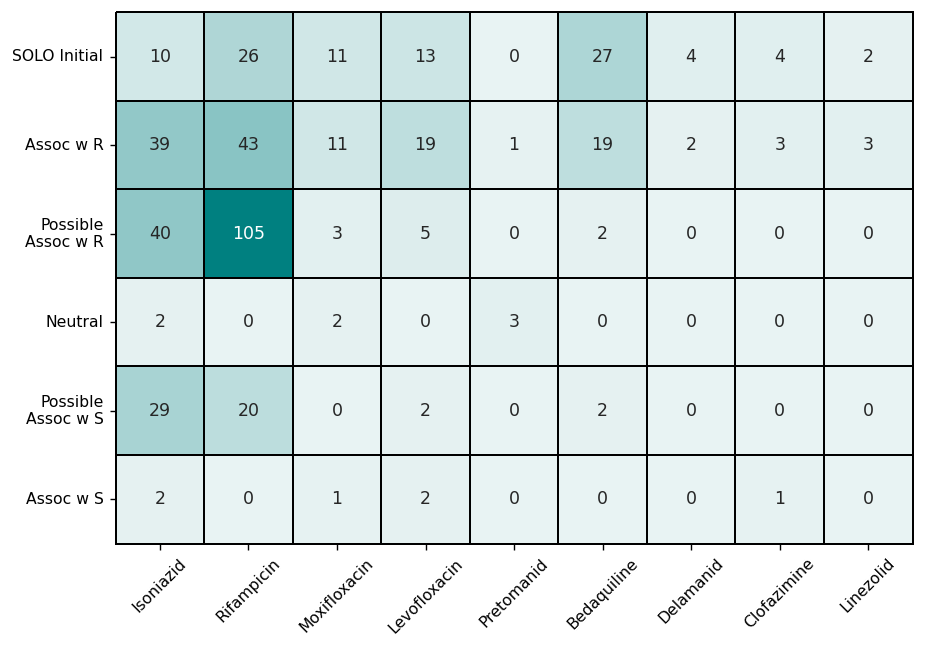

In [63]:
plot_width = 9
fig, ax = plt.subplots(figsize=(plot_width-1.5, plot_width+2.5))

sns.heatmap(
            data=plot_df,
            cmap=sns.light_palette("teal", as_cmap=True),
            vmin=0,
            # vmax=1,
            cbar=False,
            square=True,
            annot=True,
            annot_kws={"size": 10},
            fmt='g',
            linewidths=0.25, 
            linecolor='black',
            ax=ax,
            clip_on=False
           )

label_size = 9
plt.xticks(fontsize=label_size, rotation=45)
plt.yticks(fontsize=label_size, rotation=0)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.savefig("../results/20230727_prelim_heatmap_counts_with_SOLO", dpi=300)

In [104]:
df = pd.read_csv("../results/FINAL/Isoniazid.csv")
df.query("regression_confidence=='Neutral'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
397,Rv1129c_c.936G>A,2,synonymous_variant,1253599,0.997793,0.661948,0.0,1.0,0.0,6,...,0.000000,NaN,1.000058,1.000527,Neutral,-0.008863,0.531648,BOV_AFRI,3) Uncertain significance,WHO
553,dnaA_c.1302C>T,2,synonymous_variant,1302,0.992836,0.661948,0.0,1.0,0.0,6,...,0.983573,72.043402,0.999267,1.000011,Neutral,-0.004670,0.531648,4.3.3,3) Uncertain significance,WHO


In [105]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-52C>A', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', ]
compens_lst = ["ahpC_" + val for val in compens_lst]

# 'c.-42T>C' not in dataset, but 'c.-42T>G' is
neutral_lst = ['c.-88G>A', 'c.-46G>A', 'c.-84T>C', 'c.-42T>C', 'c.-42T>G', 'c.-88G>A', 'c.-10G>A', 'c.33G>A']
neutral_lst = ["ahpC_" + val for val in neutral_lst]

In [107]:
df.query("mutation in @compens_lst").sort_values(by="regression_confidence")[["mutation", "PPV_LB", "Initial_Confidence_Grading", "regression_confidence"]]

,mutation,PPV_LB,Initial_Confidence_Grading,regression_confidence
1130,ahpC_c.-57C>T,0.857459,3) Uncertain significance,Assoc w R - strict
1131,ahpC_c.-48G>A,0.869107,3) Uncertain significance,Assoc w R - strict
1133,ahpC_c.-52C>T,0.830272,3) Uncertain significance,Assoc w R - strict
1134,ahpC_c.-54C>T,0.824608,3) Uncertain significance,Assoc w R - strict
1140,ahpC_c.-76T>A,0.810294,3) Uncertain significance,Assoc w R - strict
1148,ahpC_c.-72C>T,0.763363,3) Uncertain significance,Assoc w R - strict
1146,ahpC_c.-47_-46insT,0.953808,3) Uncertain significance,Possible Assoc w R
1153,ahpC_c.-52C>A,0.883797,3) Uncertain significance,Possible Assoc w R
1163,ahpC_c.-51G>A,0.727041,3) Uncertain significance,Possible Assoc w R
1250,ahpC_c.-81C>T,0.750196,3) Uncertain significance,Possible Assoc w R


In [131]:
a = np.load("../data/pca_explained_var_ratio.npy")

In [137]:
np.sum(a[:5]), np.sum(a[:10]), np.sum(a[:50])

(0.8125600011651415, 0.9157450438061712, 0.999048108689211)

In [127]:
for drug in drugs_lst:

    if drug not in ["Rifampicin", "Isoniazid"]:
        df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
        for path in ["tiers=1+2/phenos=ALL/dropAF_withSyn_unpooled"]:
            if os.path.isfile(os.path.join(analysis_dir, drug, "BINARY", path, "model_matrix.pkl")):
                model_matrix = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", path, "model_matrix.pkl"))
                #print(drug, len(df_phenos.sample_id.unique()), len(model_matrix),  len(df_phenos.sample_id.unique()) - len(model_matrix))
                print(drug, model_matrix.shape[1])

Moxifloxacin 2553
Levofloxacin 2885
Bedaquiline 1451
Delamanid 937
Clofazimine 1874
Linezolid 521


In [129]:
drug = "Pretomanid"
for path in ["tiers=1/phenos=ALL/dropAF_withSyn_unpooled"]:
    if os.path.isfile(os.path.join(analysis_dir, drug, "BINARY", path, "model_matrix.pkl")):
        model_matrix = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", path, "model_matrix.pkl"))
        #print(drug, len(df_phenos.sample_id.unique()), len(model_matrix),  len(df_phenos.sample_id.unique()) - len(model_matrix))
        print(drug, model_matrix.shape[1])

Pretomanid 87


In [117]:
tiers_lst = ["1", "2"]

for drug in drugs_lst:

    if drug not in ["Isoniazid", "Rifampicin", "Levofloxacin", "Moxifloxacin", "Pretomanid"]:
        df_genos = pd.concat([pd.read_csv(os.path.join(analysis_dir, drug, f"genos_{num}.csv.gz"), compression="gzip", usecols=["resolved_symbol", "variant_category"]) for num in tiers_lst], axis=0).drop_duplicates()
        df_genos["mutation"] = df_genos["resolved_symbol"] + "_" + df_genos["variant_category"]
        print(drug, len(df_genos.mutation.unique()))

Bedaquiline 1904
Delamanid 953
Clofazimine 2405
Linezolid 1408


In [122]:
df_genos_PTM = pd.read_csv(os.path.join(analysis_dir, "Pretomanid", "genos_1.csv.gz"), compression="gzip", usecols=["resolved_symbol", "variant_category"]).drop_duplicates()
df_genos_PTM["mutation"] = df_genos_PTM["resolved_symbol"] + "_" + df_genos_PTM["variant_category"]
len(df_genos_PTM.mutation.unique())

95

In [140]:
df.query("mutation.str.contains('ahpC') & predicted_effect == 'missense_variant' & regression_confidence == 'Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
1135,ahpC_p.Asp73His,1,missense_variant,2726409,1.131113,0.0,1.0,0.001825,1.0,74,...,9.990215,100.666661,0.995855,0.997473,Assoc w R - strict,0.056271,0.246126,4.1.1.3,3) Uncertain significance,ALL


In [128]:
tiers_lst = ["1", "2"]

for drug in drugs_lst:

    if drug in ["Moxifloxacin", "Levofloxacin"]:
        df_genos = pd.concat([pd.read_csv(os.path.join(analysis_dir, drug, f"genos_{num}.csv.gz"), compression="gzip", usecols=["resolved_symbol", "variant_category"]) for num in tiers_lst], axis=0).drop_duplicates()
        df_genos["mutation"] = df_genos["resolved_symbol"] + "_" + df_genos["variant_category"]
        print(drug, len(df_genos.mutation.unique()))

Moxifloxacin 4022
Levofloxacin 4395


In [91]:
df.query("mutation in @neutral_lst")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
1908,ahpC_c.-42T>G,1,upstream_gene_variant,2726151,1.007108,0.591945,0.050110,1.0,0.000000,1,...,NaN,inf,0.999856,1.000047,Uncertain,NaN,NaN,4.9,3) Uncertain significance,ALL
2552,ahpC_c.-84T>C,1,upstream_gene_variant,2726109,0.985131,0.591945,0.865857,1.0,0.500654,2,...,0.000000,NaN,0.999972,1.000173,Uncertain,NaN,NaN,3,3) Uncertain significance,ALL
2581,ahpC_c.-10G>A,1,upstream_gene_variant,2726183,0.984156,0.591945,0.865857,1.0,0.539933,2,...,0.000000,NaN,0.999972,1.000173,Uncertain,NaN,NaN,5,3) Uncertain significance,ALL
2709,ahpC_c.-88G>A,1,upstream_gene_variant,2726105,0.964453,0.433937,1.000000,1.0,0.000000,5405,...,0.470984,0.528052,1.076785,1.090038,Uncertain,0.027747,0.528859,NaN,5) Not assoc w R,ALL


In [92]:
df.query("mutation in ['ahpC_c.-42T>G', 'ahpC_c.-84T>C', 'ahpC_c.-10G>A', 'ahpC_c.-88G>A']")[["mutation", "Odds_Ratio", "BH_neutral_pval", "BH_LRT_neutral_pval", "Num_Isolates", "Initial_Confidence_Grading", "regression_confidence"]].sort_values("mutation", ascending=False)

,mutation,Odds_Ratio,BH_neutral_pval,BH_LRT_neutral_pval,Num_Isolates,Initial_Confidence_Grading,regression_confidence
2709,ahpC_c.-88G>A,0.964453,1.000000,0.000000,5405,5) Not assoc w R,Uncertain
2552,ahpC_c.-84T>C,0.985131,0.865857,0.500654,2,3) Uncertain significance,Uncertain
1908,ahpC_c.-42T>G,1.007108,0.050110,0.000000,1,3) Uncertain significance,Uncertain
2581,ahpC_c.-10G>A,0.984156,0.865857,0.539933,2,3) Uncertain significance,Uncertain


In [88]:
df.query("Tier==1 & Initial_Confidence_Grading=='5) Not assoc w R' & predicted_effect=='synonymous_variant'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
2739,katG_c.723C>G,1,synonymous_variant,2155389,1.073730,0.000000,1.000000,0.559319,0.998778,199,...,1.278354,2.234261,0.996590,0.998997,Possible Assoc w R,0.033688,0.529668,4.6.2.2,5) Not assoc w R,ALL
2740,katG_c.87C>A,1,synonymous_variant,2156025,1.043859,0.291896,1.000000,1.000000,0.554209,207,...,0.051222,0.157373,1.005386,1.007500,Uncertain,0.069702,0.342095,BOV_AFRI,5) Not assoc w R,ALL
2852,katG_c.609C>T,1,synonymous_variant,2155503,0.995089,0.605640,0.299108,1.000000,0.000000,338,...,0.053652,0.132351,1.009317,1.012031,Uncertain,0.024597,0.529668,NaN,5) Not assoc w R,ALL
3099,ahpC_c.186T>A,1,synonymous_variant,2726378,0.971048,0.605640,0.522968,1.000000,0.364614,54,...,0.000000,NaN,1.001437,1.002484,Uncertain,-0.005157,0.529668,NaN,5) Not assoc w R,ALL
3107,inhA_c.9A>C,1,synonymous_variant,1674210,0.947079,0.000000,1.000000,0.598440,0.998778,364,...,0.403466,0.638396,1.003249,1.006265,Possible Assoc w S,-0.075590,0.064143,2.2.1,5) Not assoc w R,ALL


In [66]:
df.query("regression_confidence=='Neutral'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
397,Rv1129c_c.936G>A,2,synonymous_variant,1253599,0.997793,0.661948,0.0,1.0,0.0,6,...,0.000000,NaN,1.000058,1.000527,Neutral,-0.008863,0.531648,BOV_AFRI,3) Uncertain significance,WHO
553,dnaA_c.1302C>T,2,synonymous_variant,1302,0.992836,0.661948,0.0,1.0,0.0,6,...,0.983573,72.043402,0.999267,1.000011,Neutral,-0.004670,0.531648,4.3.3,3) Uncertain significance,WHO


In [73]:
df.query("mutation in ['ahpC_c.-42T>G', 'ahpC_c.-84T>C', 'ahpC_c.-10G>A', 'ahpC_c.-88G>A']")[["mutation", "BH_neutral_pval", "Num_Isolates", "Initial_Confidence_Grading", "regression_confidence"]].sort_values("mutation", ascending=False)

,mutation,BH_neutral_pval,Num_Isolates,Initial_Confidence_Grading,regression_confidence
2738,ahpC_c.-88G>A,1.000000,5405,5) Not assoc w R,Uncertain
2584,ahpC_c.-84T>C,0.865857,2,3) Uncertain significance,Uncertain
1942,ahpC_c.-42T>G,0.050110,1,3) Uncertain significance,Uncertain
2613,ahpC_c.-10G>A,0.865857,2,3) Uncertain significance,Uncertain


# Compare Mutations Uncertain vs. Not between WHO and ALL

In [13]:
def make_solo_regression_comparison_table(drug, tiers_lst=[1, 2], folder="FINAL"):
        
    df = pd.read_csv(f"../results/{folder}/{drug}.csv")
    df = df.query("Tier in @tiers_lst")    
    
    # combine with solo results
    df = solo_results.query("drug==@drug").merge(df[["mutation", "regression_confidence"]], 
                                                 on="mutation", how="outer"
                                                )
    
    # create a mapping between the categories of the SOLO algorithm and regression so that they can be compared
    confidence_mapping = {'1) Assoc w R': "Assoc w R - strict",
                           "2) Assoc w R - Interim": "Possible Assoc w R",
                           "3) Uncertain significance": "Uncertain",
                           "4) Not assoc w R - Interim": "Possible Assoc w S",
                           '5) Not assoc w R': "Assoc w S - strict"
                          }

    confidence_mapping_rev = {val: key for (key, val) in confidence_mapping.items()}

    # all pairs (exhaustive list, so 5 x 5)
    pairs = list(itertools.product(confidence_mapping_rev.values(), confidence_mapping_rev.values()))

    # neutral mutations are in the 5) Not assoc w R category because they pass the Num_Isolates ≥ 5 threshold
    confidence_mapping_rev["Neutral"] = "5) Not assoc w R"
    
    # add new column denoting the gradings of the regression model, if they were transformed to the list they use
    df["Regression_Confidence_Grading"] = df["regression_confidence"].map(confidence_mapping_rev)
    
    # get counts of mutations across the groups
    counts_df = pd.DataFrame(df[["Initial_Confidence_Grading", "Regression_Confidence_Grading"]].value_counts()).rename(columns={"count":"Count"}).reset_index()
    
    # for pairs that are 0, they won't appear in the above dataframe, so manually add them with Count = 0
    for (a, b) in pairs:

        if len(counts_df.query("Initial_Confidence_Grading==@a & Regression_Confidence_Grading==@b")) == 0:
            counts_df = pd.concat([counts_df, pd.DataFrame({"Initial_Confidence_Grading": a, 
                                                            "Regression_Confidence_Grading": b,
                                                            "Count": 0
                                                           }, index=[0])])

    counts_df = counts_df.reset_index(drop=True)
    assert len(counts_df) == len(pairs)
    
    # return both the dataframe of mutation and the summary counts dataframe 
    return df, counts_df.pivot(index="Regression_Confidence_Grading", columns="Initial_Confidence_Grading", values="Count").fillna(0).astype(int)

In [14]:
tier12_comparison_tables = {}

confidence_mapping = {'1) Assoc w R': "Assoc w R - strict",
                           "2) Assoc w R - Interim": "Possible Assoc w R",
                           "3) Uncertain significance": "Uncertain",
                           "4) Not assoc w R - Interim": "Possible Assoc w S",
                           '5) Not assoc w R': "Assoc w S - strict"
                          }

for drug in drugs_lst:
    
    _, counts_df = make_solo_regression_comparison_table(drug, tiers_lst=[1, 2], folder="FINAL")
    tier12_comparison_tables[drug] = counts_df
    
summed_tier12_variants_across_drugs = reduce(lambda x, y: x.add(y, fill_value=0), list(tier12_comparison_tables.values()))
summed_tier12_variants_across_drugs

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,25,0,17,0,1
2) Assoc w R - Interim,0,0,105,0,0
3) Uncertain significance,0,0,5935,2,75
4) Not assoc w R - Interim,0,0,12,0,8
5) Not assoc w R,0,0,0,0,0


In [18]:
df = pd.read_csv("../results/FINAL/Rifampicin.csv")

In [23]:
df.query("regression_confidence=='Uncertain' & Initial_Confidence_Grading=='5) Not assoc w R' & Tier == 1")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
26,rpoB_p.Glu639Asp,1,missense_variant,761723,0.994083,0.514265,0.032016,0.882063,0.491288,59,...,0.055556,0.422790,1.001257,1.002666,Uncertain,0.010744,0.580119,6,5) Not assoc w R,WHO
27,rpoB_p.Ser388Leu,1,missense_variant,760969,0.986553,0.707765,0.002391,0.882063,0.491288,60,...,0.054597,0.414985,1.001294,1.002713,Uncertain,0.010744,0.580119,NaN,5) Not assoc w R,WHO
33,rpoB_c.-261A>G,1,upstream_gene_variant,759546,0.966410,0.172032,1.000000,0.882063,0.580808,475,...,0.144641,0.274003,1.012789,1.016968,Uncertain,0.013264,0.580119,NaN,5) Not assoc w R,WHO
39,rpoB_c.687C>A,1,synonymous_variant,760493,0.923967,0.013424,1.000000,0.904304,0.798013,77,...,0.000000,NaN,1.002524,1.003979,Uncertain,0.002382,0.581823,4.1.1.1,5) Not assoc w R,WHO
976,rpoB_c.684C>T,1,synonymous_variant,760490,1.043251,0.389645,1.000000,1.000000,0.670572,649,...,0.169717,0.280091,1.013221,1.016953,Uncertain,0.003209,0.581823,1.1.2,5) Not assoc w R,ALL
978,rpoB_c.300G>A,1,synonymous_variant,760106,1.036064,0.012616,1.000000,1.000000,0.901414,318,...,0.327332,0.573368,1.003415,1.006194,Uncertain,0.025272,0.581823,4.1.2.1,5) Not assoc w R,ALL
1325,rpoB_c.1683G>A,1,synonymous_variant,761489,0.957996,0.012616,1.000000,1.000000,0.883892,351,...,1.356709,2.059418,0.994168,0.997692,Uncertain,-0.028625,0.581823,4.2.2,5) Not assoc w R,ALL
1326,rpoB_c.309C>T,1,synonymous_variant,760115;760112,0.925452,0.088406,1.000000,1.000000,0.803702,4126,...,0.531952,0.611279,1.043674,1.054953,Uncertain,0.125017,0.581823,NaN,5) Not assoc w R,ALL
1327,rpoB_c.3225T>C,1,synonymous_variant,763028;763025;763031,0.904521,0.012616,1.000000,1.000000,0.990570,24325,...,1.139660,1.180477,0.830130,0.865029,Uncertain,0.002078,0.581823,NaN,5) Not assoc w R,ALL
1328,rpoB_c.2628T>G,1,synonymous_variant,762434,0.895181,0.023768,1.000000,1.000000,0.765895,5356,...,0.396795,0.453024,1.088908,1.101994,Uncertain,-0.228383,0.581823,NaN,5) Not assoc w R,ALL


In [21]:
df.query("regression_confidence=='Assoc w R - strict' & Initial_Confidence_Grading=='3) Uncertain significance'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
100,rpoB_p.Leu430Pro,1,missense_variant,761095,1.242911,0.0,1.0,9.129684e-50,1.00000,395,...,1.719855,2.548647,0.991427,0.995271,Assoc w R - strict,0.196684,0.000000,NaN,3) Uncertain significance,ALL
103,rpoB_p.Asp435Gly,1,missense_variant,761108;761110;761107,1.223567,0.0,1.0,4.376011e-27,1.00000,156,...,15.529846,59.637233,0.989942,0.992833,Assoc w R - strict,0.273147,0.000000,NaN,3) Uncertain significance,ALL
106,rpoB_p.His445Asn,1,missense_variant,761139,1.199104,0.0,1.0,4.459894e-38,1.00000,209,...,2.104206,3.653493,0.993699,0.996595,Assoc w R - strict,0.130224,0.000000,NaN,3) Uncertain significance,ALL
111,rpoB_p.Ile491Leu,1,missense_variant,761277,1.112488,0.0,1.0,1.706355e-05,1.00000,31,...,NaN,inf,0.997462,0.998783,Assoc w R - strict,0.103040,0.013167,NaN,3) Uncertain significance,ALL
112,rpoB_p.Met434Ile,1,missense_variant,761108,1.111927,0.0,1.0,1.342147e-09,1.00000,34,...,7.145414,124.379135,0.997450,0.998804,Assoc w R - strict,0.064771,0.346385,NaN,3) Uncertain significance,ALL
115,rpoB_p.Asp435Glu,1,missense_variant,761111,1.110382,0.0,1.0,2.604791e-07,1.00000,23,...,NaN,inf,0.998038,0.999176,Assoc w R - strict,0.051283,0.474000,NaN,3) Uncertain significance,ALL
118,rpoB_p.His445Pro,1,missense_variant,761140,1.098210,0.0,1.0,2.165748e-10,1.00000,8,...,NaN,inf,0.999180,0.999851,Assoc w R - strict,0.127433,0.013167,NaN,3) Uncertain significance,ALL
120,rpoB_p.Phe424Val,1,missense_variant,761076,1.092499,0.0,1.0,6.812451e-04,1.00000,18,...,NaN,inf,0.998406,0.999413,Assoc w R - strict,0.072330,0.366679,NaN,3) Uncertain significance,ALL
121,rpoB_p.Ser493Leu,1,missense_variant,761284,1.090796,0.0,1.0,5.399783e-05,1.00000,17,...,NaN,inf,0.998481,0.999460,Assoc w R - strict,0.050648,0.578049,NaN,3) Uncertain significance,ALL
122,rpoB_p.His445Ser,1,missense_variant,761139,1.085998,0.0,1.0,1.318586e-12,1.00000,22,...,1.628247,9.790417,0.998829,0.999809,Assoc w R - strict,0.056725,0.396436,NaN,3) Uncertain significance,ALL


In [15]:
tier1_comparison_tables = {}

confidence_mapping = {'1) Assoc w R': "Assoc w R - strict",
                           "2) Assoc w R - Interim": "Possible Assoc w R",
                           "3) Uncertain significance": "Uncertain",
                           "4) Not assoc w R - Interim": "Possible Assoc w S",
                           '5) Not assoc w R': "Assoc w S - strict"
                          }

for drug in drugs_lst:
    
    _, counts_df = make_solo_regression_comparison_table(drug, tiers_lst=[1], folder="FINAL")
    tier1_comparison_tables[drug] = counts_df
    
summed_tier1_variants_across_drugs = reduce(lambda x, y: x.add(y, fill_value=0), list(tier1_comparison_tables.values()))
summed_tier1_variants_across_drugs

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,25,0,16,0,0
2) Assoc w R - Interim,0,0,44,0,0
3) Uncertain significance,0,0,1169,1,10
4) Not assoc w R - Interim,0,0,5,0,5
5) Not assoc w R,0,0,0,0,0


In [17]:
tier1_comparison_tables["Rifampicin"]

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,25,0,16,0,0
2) Assoc w R - Interim,0,0,44,0,0
3) Uncertain significance,0,0,1169,1,10
4) Not assoc w R - Interim,0,0,5,0,5
5) Not assoc w R,0,0,0,0,0


In [179]:
tier12_comparison_tables["Bedaquiline"]

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,19,0,0,0,0
2) Assoc w R - Interim,0,0,2,0,0
3) Uncertain significance,6,0,1423,5,0
4) Not assoc w R - Interim,0,0,1,0,1
5) Not assoc w R,0,0,0,0,0


In [34]:
tier2_comparison_tables = {}

confidence_mapping = {'1) Assoc w R': "Assoc w R - strict",
                           "2) Assoc w R - Interim": "Possible Assoc w R",
                           "3) Uncertain significance": "Uncertain",
                           "4) Not assoc w R - Interim": "Possible Assoc w S",
                           '5) Not assoc w R': "Assoc w S - strict"
                          }

for drug in drugs_lst:
    
    _, counts_df = make_solo_regression_comparison_table(drug, tiers_lst=[2], folder="FINAL")
    tier2_comparison_tables[drug] = counts_df
    
summed_tier2_variants_across_drugs = reduce(lambda x, y: x.add(y, fill_value=0), list(tier2_comparison_tables.values()))
summed_tier2_variants_across_drugs

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,0,0,1,0,1
2) Assoc w R - Interim,0,0,65,0,0
3) Uncertain significance,0,0,9429,3,88
4) Not assoc w R - Interim,0,0,8,0,3
5) Not assoc w R,0,0,1,0,0


In [74]:
tier2_comparison_tables["Rifampicin"]

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,0,0,1,0,1
2) Assoc w R - Interim,0,0,61,0,0
3) Uncertain significance,0,0,4766,1,65
4) Not assoc w R - Interim,0,0,7,0,3
5) Not assoc w R,0,0,0,0,0


In [84]:
df = pd.read_csv("../results/FINAL/Rifampicin.csv")
df.query("Tier==2 & regression_confidence=='Assoc w R - strict' & Initial_Confidence_Grading=='3) Uncertain significance'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
4625,glpK_lof,2,lof,NaN,1.10015,0.0,1.0,0.011574,0.99911,496,...,2.519752,3.609437,0.982819,0.988058,Assoc w R - strict,0.174653,0.0,NaN,3) Uncertain significance,ALL


In [89]:
df.query("mutation.str.contains('glpK') & regression_confidence.str.contains('Assoc w R')")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
1356,glpK_p.Val192fs,2,frameshift,4139189;4139186;4139183;4138635;4139181;413918...,1.087527,0.0,1.0,0.593094,1.000000,421,...,3.196412,4.795773,0.982443,0.987407,Assoc w R - strict,0.170254,0.000000,NaN,5) Not assoc w R,ALL
1448,glpK_c.-5A>G,2,upstream_gene_variant,4139760,1.036328,0.0,1.0,1.000000,0.974487,25,...,0.933871,4.482941,0.998966,1.000091,Possible Assoc w R,-0.022820,0.590385,2.2.1,3) Uncertain significance,ALL
4625,glpK_lof,2,lof,NaN,1.100150,0.0,1.0,0.011574,0.999110,496,...,2.519752,3.609437,0.982819,0.988058,Assoc w R - strict,0.174653,0.000000,NaN,3) Uncertain significance,ALL


In [97]:
df.query("mutation=='rpoC_p.Glu1092Asp'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
40,rpoC_p.Glu1092Asp,2,missense_variant,766645,1.14519,0.012686,1.0,1.0,0.848583,2651,...,3.344444,3.885188,0.861217,0.877879,Uncertain,-0.058445,0.590385,2.2.1,5) Not assoc w R,WHO


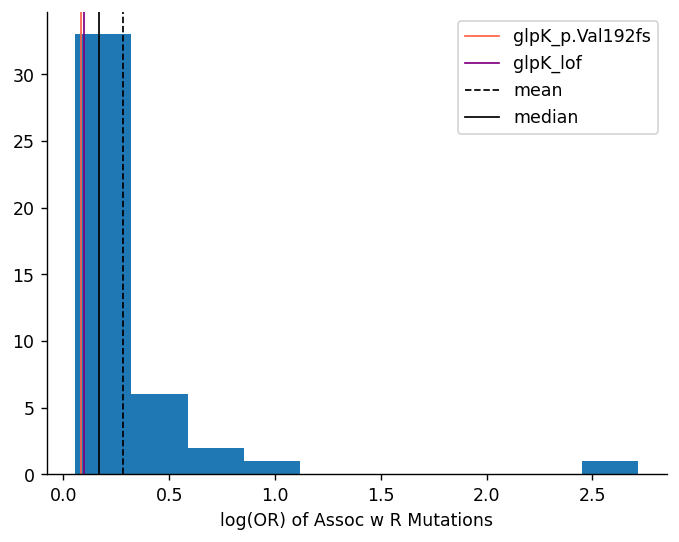

In [96]:
plt.hist(np.log(df.query("regression_confidence=='Assoc w R - strict'")["Odds_Ratio"]))

width=1
variant = 'glpK_p.Val192fs'
plt.axvline(x=np.log(df.query("mutation==@variant")["Odds_Ratio"].values[0]), label=variant, color="tomato", linewidth=width)
plt.axvline(x=np.log(df.query("mutation=='glpK_lof'")["Odds_Ratio"].values[0]), label='glpK_lof', color="purple", linewidth=width)
plt.axvline(x=np.mean(np.log(df.query("regression_confidence=='Assoc w R - strict'")["Odds_Ratio"])), label="mean", color="black", linestyle='--', linewidth=width)
plt.axvline(x=np.median(np.log(df.query("regression_confidence=='Assoc w R - strict'")["Odds_Ratio"])), label="median", color="black", linewidth=width)
plt.legend()
sns.despine()
plt.xlabel("log(OR) of Assoc w R Mutations")
plt.savefig("../results/glpK_OR.png", dpi=300)

# Compare Mutations Uncertain vs. Not in SOLO V2

In [132]:
drug = "Bedaquiline"
df = pd.read_csv(f"../results/FINAL/{drug}.csv")

In [133]:
df.query("regression_confidence=='Uncertain' & Initial_Confidence_Grading in ['1) Assoc w R', '5) Not assoc w R']")[['mutation', 'Tier', 'predicted_effect', 'Odds_Ratio', 'BH_pval', 'Mut_R', 'Mut_S', 'NoMut_S', 'NoMut_R', 'PPV', 'NPV', 'regression_confidence', 'Initial_Confidence_Grading']]

,mutation,Tier,predicted_effect,Odds_Ratio,BH_pval,Mut_R,Mut_S,NoMut_S,NoMut_R,PPV,NPV,regression_confidence,Initial_Confidence_Grading
5,Rv0678_p.Met146Thr,1,missense_variant,1.138015,0.0,11,37,12947,868,0.229167,0.93717,Uncertain,1) Assoc w R


In [137]:
df.query("regression_confidence.str.contains('strict') & Initial_Confidence_Grading == '3) Uncertain significance'")[['mutation', 'Tier', 'predicted_effect', 'Odds_Ratio', 'BH_pval', 'Mut_R', 'Mut_S', 'NoMut_S', 'NoMut_R', 'PPV', 'NPV', 'regression_confidence', 'Initial_Confidence_Grading']]

,mutation,Tier,predicted_effect,Odds_Ratio,BH_pval,Mut_R,Mut_S,NoMut_S,NoMut_R,PPV,NPV,regression_confidence,Initial_Confidence_Grading
27,Rv0678_p.Leu142Arg,1,missense_variant,1.073962,0.0,7,2,12982,872,0.777778,0.937058,Assoc w R - strict,3) Uncertain significance
619,mmpL5_p.Arg202fs,1,frameshift,0.916630,0.0,0,19,12965,879,0.000000,0.936507,Assoc w S - strict,3) Uncertain significance
628,mmpL5_lof,1,lof,0.667528,0.0,0,246,12740,879,0.000000,0.935458,Assoc w S - strict,3) Uncertain significance


In [135]:
df.query("regression_confidence == 'Assoc w R - strict' & Initial_Confidence_Grading == '5) Not assoc w R'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos


In [136]:
df.query("regression_confidence == 'Assoc w S - strict' & Initial_Confidence_Grading == '1) Assoc w R'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos


In [181]:
drug = "Bedaquiline"
df = pd.read_csv(f"../results/FINAL/{drug}.csv")
df.shape

(1467, 38)

In [182]:
df.query("regression_confidence=='Uncertain' & Initial_Confidence_Grading in ['1) Assoc w R', '5) Not assoc w R']")[['mutation', 'Tier', 'predicted_effect', 'Odds_Ratio', 'BH_pval', 'Mut_R', 'Mut_S', 'NoMut_S', 'NoMut_R', 'PPV', 'NPV', 'regression_confidence', 'Initial_Confidence_Grading']]

,mutation,Tier,predicted_effect,Odds_Ratio,BH_pval,Mut_R,Mut_S,NoMut_S,NoMut_R,PPV,NPV,regression_confidence,Initial_Confidence_Grading
0,atpE_p.Ala63Pro,1,missense_variant,1.125689,0.000000,4,0,1248,759,1.000000,0.621824,Uncertain,1) Assoc w R
1,Rv0678_p.Asp165fs,1,frameshift,1.104991,0.048653,4,0,1248,759,1.000000,0.621824,Uncertain,1) Assoc w R
2,Rv0678_p.Ala36Val,1,missense_variant,1.097825,0.041786,4,0,1248,759,1.000000,0.621824,Uncertain,1) Assoc w R
3,Rv0678_p.Tyr157fs,1,frameshift,1.089496,0.102375,3,0,1248,760,1.000000,0.621514,Uncertain,1) Assoc w R
4,Rv0678_p.Asn70Asp,1,missense_variant,1.071955,0.099483,5,0,1248,758,1.000000,0.622134,Uncertain,1) Assoc w R
14,Rv0678_p.Met146Thr,1,missense_variant,1.138015,0.000000,11,37,12947,868,0.229167,0.937170,Uncertain,1) Assoc w R


In [141]:
df.query("regression_confidence.str.contains('strict') & Initial_Confidence_Grading == '3) Uncertain significance'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos


In [190]:
df.query("mutation=='mmpS5_c.-74G>T'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
12,mmpS5_c.-74G>T,1,upstream_gene_variant,778979,1.211979,0.0,1.0,3.606738e-36,1.0,121,...,3.566606,7.908681,0.957782,0.982871,Uncertain,-0.008292,0.408358,2.2.1,4) Not assoc w R - Interim,ALL


In [191]:
df.query("regression_confidence=='Uncertain' & Initial_Confidence_Grading=='4) Not assoc w R - Interim'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos
12,mmpS5_c.-74G>T,1,upstream_gene_variant,778979,1.211979,0.000000,1.00000,3.606738e-36,1.000000,121,...,3.566606,7.908681,0.957782,0.982871,Uncertain,-0.008292,0.408358,2.2.1,4) Not assoc w R - Interim,ALL
16,mmpL5_p.Thr794Ile,1,missense_variant,776099;776096;776100,1.120262,0.000000,1.00000,1.282231e-01,1.000000,7478,...,1.301997,1.423270,0.536345,0.664333,Uncertain,0.404974,0.000000,NaN,4) Not assoc w R - Interim,ALL
605,mmpL5_p.Ile948Val,1,missense_variant,775639,0.977246,0.509136,0.86315,9.142814e-01,0.738936,13803,...,0.991760,1.002915,0.708079,3.804282,Uncertain,0.004650,0.469141,NaN,4) Not assoc w R - Interim,ALL
827,Rv1979c_c.-129A>G,2,upstream_gene_variant,2223293,1.048011,0.296070,1.00000,1.000000e+00,0.979173,13595,...,1.000270,1.013790,0.281855,1.149625,Uncertain,0.081629,0.000000,NaN,4) Not assoc w R - Interim,ALL
1231,Rv1979c_p.Asp286Gly,2,missense_variant,2222308,0.959195,0.133415,1.00000,1.000000e+00,0.654962,837,...,1.008040,1.629419,0.963204,1.001511,Uncertain,-0.059180,0.416293,NaN,4) Not assoc w R - Interim,ALL


In [142]:
df.query("regression_confidence == 'Assoc w R - strict' & Initial_Confidence_Grading == '5) Not assoc w R'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos


In [143]:
df.query("regression_confidence == 'Assoc w S - strict' & Initial_Confidence_Grading == '1) Assoc w R'")

,mutation,Tier,predicted_effect,position,Odds_Ratio,BH_pval,BH_neutral_pval,BH_LRT_pval,BH_LRT_neutral_pval,Num_Isolates,...,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,MIC_coef,BH_MIC_pval,single_lineage,Initial_Confidence_Grading,Phenos


In [144]:
df.query("mutation in ['Rv0678_p.Leu142Arg', 'mmpL5_p.Arg202fs', 'mmpL5_lof']")[['mutation', 'Tier', 'predicted_effect', 'Odds_Ratio', 'BH_pval', 'Mut_R', 'Mut_S', 'NoMut_S', 'NoMut_R', 'PPV', 'NPV', 'regression_confidence', 'Initial_Confidence_Grading']]

,mutation,Tier,predicted_effect,Odds_Ratio,BH_pval,Mut_R,Mut_S,NoMut_S,NoMut_R,PPV,NPV,regression_confidence,Initial_Confidence_Grading
5,Rv0678_p.Leu142Arg,1,missense_variant,1.060756,0.023739,1,0,1248,762,1.0,0.620896,Uncertain,3) Uncertain significance
6,mmpL5_p.Arg202fs,1,frameshift,0.942680,0.003792,0,1,1247,763,0.0,0.620398,Uncertain,3) Uncertain significance
7,mmpL5_lof,1,lof,0.796466,0.000000,0,4,1244,763,0.0,0.619831,Uncertain,3) Uncertain significance


# Prediction Model AUC vs. Classification AUC

In [113]:
for drug in drugs_lst:
    if len(solo_results.query("drug==@drug & Initial_Confidence_Grading=='1) Assoc w R'")):
        print(drug)

Rifampicin
Moxifloxacin
Levofloxacin
Bedaquiline
Delamanid
Clofazimine
Linezolid


In [194]:
dfs_lst = []

for drug in drugs_lst:

    for path in [f"tiers=1/phenos=ALL", f"tiers=1+2/phenos=ALL"]:
        if os.path.isfile(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_bootstrap.csv")):
            df = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_bootstrap.csv"))
            df["Drug"] = drug

            if "2" in path:
                df["Tier"] = 2
            else:
                df["Tier"] = 1
                
            dfs_lst.append(df)
        else:
            print(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_bootstrap.csv"))

dfs_lst = pd.concat(dfs_lst, axis=0)
del dfs_lst["Catalog"]
del dfs_lst["CV"]

/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Rifampicin/BINARY/tiers=1+2/phenos=ALL/model_stats_bootstrap.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Levofloxacin/BINARY/tiers=1+2/phenos=ALL/model_stats_bootstrap.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Pretomanid/BINARY/tiers=1+2/phenos=ALL/model_stats_bootstrap.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Delamanid/BINARY/tiers=1+2/phenos=ALL/model_stats_bootstrap.csv
/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Linezolid/BINARY/tiers=1+2/phenos=ALL/model_stats_bootstrap.csv


In [195]:
dfs_lst

,AUC,Sens,Spec,Precision,Accuracy,Balanced_Acc,Model,Drug,Tier
0,NaN,0.927051,0.970229,0.944471,0.954976,0.948640,Catalog,Rifampicin,1
1,0.966143,0.937786,0.972512,0.948410,0.960353,0.955149,L2_Reg,Rifampicin,1
0,NaN,0.849380,0.939263,0.750329,0.923364,0.894321,Catalog,Moxifloxacin,1
1,0.930515,0.891037,0.938511,0.748135,0.930435,0.914774,L2_Reg,Moxifloxacin,1
0,NaN,0.849380,0.939263,0.750329,0.923364,0.894321,Catalog,Moxifloxacin,2
1,0.931093,0.892083,0.937761,0.746066,0.929991,0.914922,L2_Reg,Moxifloxacin,2
0,NaN,0.847974,0.968805,0.880346,0.943066,0.908389,Catalog,Levofloxacin,1
1,0.940177,0.888809,0.967409,0.875639,0.951280,0.928109,L2_Reg,Levofloxacin,1
0,0.543307,0.071429,0.983871,0.083333,0.965517,0.527650,L2_Reg,Pretomanid,1
0,NaN,0.409836,0.991144,0.785582,0.948497,0.700490,Catalog,Bedaquiline,1


(0.0, 1.0)

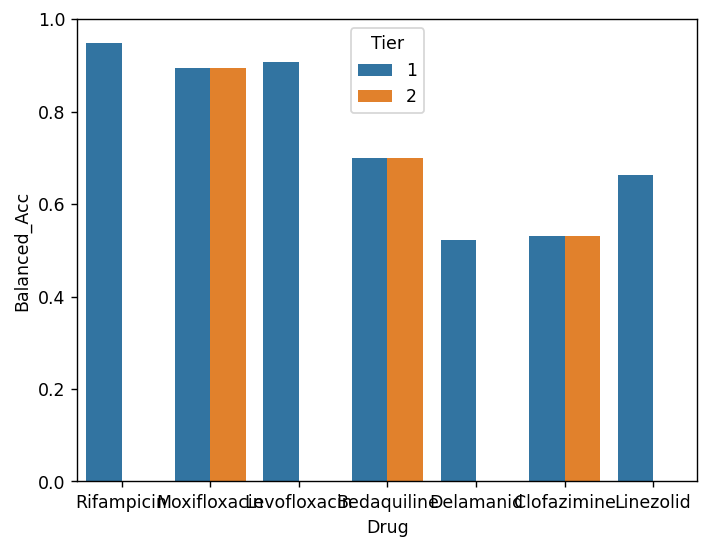

In [171]:
sns.barplot(data=dfs_lst.query("Model=='Catalog'"),
            x="Drug",
            y="Balanced_Acc",
            hue="Tier"
           )

plt.ylim(0, 1)

(0.0, 1.0)

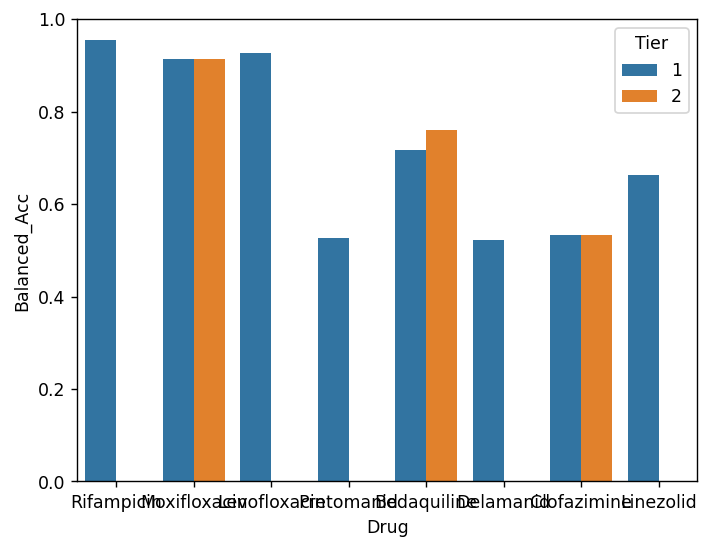

In [172]:
sns.barplot(data=dfs_lst.query("Model=='L2_Reg'"),
            x="Drug",
            y="Balanced_Acc",
            hue="Tier"
           )

plt.ylim(0, 1)

In [ ]:
cat1_mutations = results_df.query("regression_confidence == 'Assoc w R - strict' & Tier in @tiers_lst & ~mutation.str.contains('|'.join(['lof', 'inframe']))")["mutation"].values


# CC vs. CC-ATU Analyses

Export only variants that would pass the Expert rule:

<ul>
    <li>Odds Ratio > 1</li>
    <li>N_resistant (i.e. true positive) ≥ 5</li>
    <li>PPV_LB ≥ 0.25</li>
    <li>Benjamini-Hochberg p-value < 0.01</li>
</ul>

In [ ]:
# def export_cc_atu_analyses(drugs_lst, pval_thresh=0.01):
#     '''
#     This function combines the CC and CC-ATU analyses for each drug. 
#     '''
    
#     if not os.path.isdir("../results/ATU"):
#         os.mkdir("../results/ATU")
    
#     # hard coded paths to preserve the model hierarchy
#     analysis_paths = ["tiers=1/dropAF_noSyn_poolSeparate",
#                       "tiers=1/dropAF_noSyn_poolALL",
#                       "tiers=1/dropAF_noSyn_unpooled",
#                       "tiers=1+2/dropAF_noSyn_poolSeparate",
#                       "tiers=1+2/dropAF_noSyn_poolALL",
#                       "tiers=1+2/dropAF_noSyn_unpooled",
#     ]
    
#     for drug in drugs_lst:
        
#         all_analyses = {}
        
#         for i, model_path in enumerate(analysis_paths):

#             if os.path.isfile(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC.csv")):
            
#                 cc = pd.read_csv(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC.csv"))
#                 cc_atu = pd.read_csv(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC_ATU.csv"))

#                 cc.loc[(cc["Odds_Ratio"] > 1) & 
#                        (cc["TP"] >= 5) &
#                        (cc["PPV_LB"] >= 0.25) & 
#                        (cc["BH_pval"] < pval_thresh), "Expert_PASS"
#                       ] = 1

#                 cc_atu.loc[(cc_atu["Odds_Ratio"] > 1) & 
#                            (cc_atu["TP"] >= 5) &
#                            (cc_atu["PPV_LB"] >= 0.25) & 
#                            (cc_atu["BH_pval"] < pval_thresh), "Expert_PASS"
#                           ] = 1

#                 cc["ATU"] = 0
#                 cc_atu["ATU"] = 1

#                 combined_df = pd.concat([cc.query("Expert_PASS == 1"), cc_atu.query("Expert_PASS == 1")])
#                 del combined_df["Expert_PASS"]
                
#                 combined_df["Tier"] = [2 if "+2" in model_path else 1][0]
#                 combined_df["Phenos"] = ["ALL" if "ALL" in model_path else "WHO"][0]
#                 combined_df["pool_type"] = model_path.split("_")[-1]
#                 combined_df["synonymous"] = int("withSyn" in model_path)
#                 combined_df["HET"] = ["DROP" if "drop" in model_path else "AF"][0]

#                 # remove principal components
#                 combined_df = combined_df.loc[~combined_df["mutation"].str.contains("PC", case=True)]
            
#                 all_analyses[f"Model_{i+1}"] = combined_df.sort_values("Odds_Ratio", ascending=False)

#         if len(all_analyses) > 0:
                
#             with pd.ExcelWriter(f"../results/ATU/{drug}.xlsx") as file:

#                 for key, val in all_analyses.items():
#                     val.to_excel(file, sheet_name=key, index=False)
                  
#             print(f"Finished {drug}!")

In [ ]:
# export_cc_atu_analyses(drugs_lst)